In [21]:
%matplotlib inline
# Plot everything as SVG
%config InlineBackend.figure_formats=['svg']

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configure some styling
palette = ['#386DF9', '#FFDC52', '#FF1614', '#62F591', '#AA22FF', '#34495E']
sns.set(font_scale=1.1, style='darkgrid', palette=palette, context='notebook')

# Clustering

So far we've looked at supervised learning - now let's take a look at a common unsupervised learning task.

Sometimes you have a lot of data that you want to learn something about. A common question to ask is - are there any natural groups (clusters) which form in the data?

For instance - are there groups of users that behave similarly? That might provide some insight into user behavior profiles.

Or, given some characteristics about a set of flowers - do some characteristics appear together more often? If we can find clusters there, we might be looking at different species.

### Example: Identifying new deer species

![](../assets/sawsbuck3.png)

We've collected more heights and weights of deer from different locations and noticed they tend to vary from location to location. We suspect that these deer populations may be distinct enough to qualify as separate species (NB: I'm not a biologist).

Let's see if any natural groupings form to support this idea.

In [136]:
deer_data = pd.read_csv('../data/deer_cluster_data.csv')
deer_data.head()

,Weight,Height
0,214.586835,168.378228
1,247.171770,196.529935
2,216.964749,169.599983
3,240.211130,196.495348
4,185.683348,160.969367


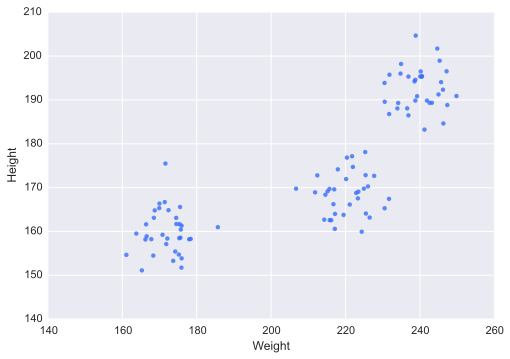

In [137]:
sns.regplot(deer_data['Weight'], deer_data['Height'], fit_reg=False)

In [138]:
from sklearn.cluster import KMeans

# The k-means algorithm requires that we specify how many clusters we expect
model = KMeans(n_clusters=3)

# The model returns labels for each datapoint
labels = model.fit_predict(deer_data.values)
labels[:10]

array([2, 1, 2, 1, 0, 2, 0, 0, 2, 1], dtype=int32)

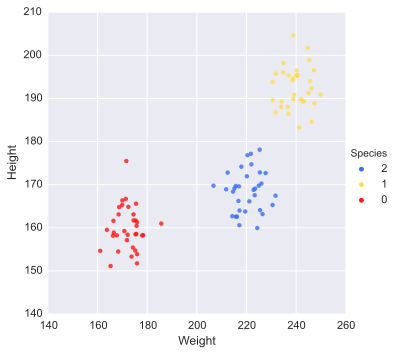

In [144]:
deer_data['Species'] = labels
sns.lmplot('Weight', 'Height', data=deer_data, fit_reg=False, hue='Species')

# Exercise: Find the emails related to crime coefficients

To round out our story, we want to uncover who's responsible for the crime coefficient formula. _Fortunately_ we have access to an email dump of several legislators involved in its development process. But - there are tens of thousands of emails, and we have a deadline to meet. We can use clustering to narrow down our search.

One of these clusters might focus on the crime coefficient formula. Then we only need to look at the crime coefficient cluster and see who sent those emails.


### Working with text

However, we're presented with another challenge - so far we've worked with numbers, which are pretty easy to deal with. But now we're dealing with text - how does a computer work with text?


#### Bag of Words

Since computers are great at working with numbers, we should turn the text into numbers. How do we do that?

We can just map numbers to words! But to do so, first we need to break up the text into words - this process is called _tokenization_.

Let's start simple and say we have the text:

> My cat is fast

The easiest way to break up the words is to split on whitespace.

In [2]:
doc = 'My cat is fast'
tokens = doc.split(' ')
tokens

['My', 'cat', 'is', 'fast']

Now we want to map these terms to numbers (ids). As an example, we can do it using a dictionary.

In [4]:
term_map = {t: i for i, t in enumerate(tokens)}
term_map

{'My': 0, 'cat': 1, 'fast': 3, 'is': 2}

Let's add another document to make things more interesting.

In [5]:
doc2 = 'This is my cat'
tokens2 = doc2.split(' ')

# Properly increment the id
last_id = 3
for t in tokens2:
    if t not in term_map:
        last_id += 1
        term_map[t] = last_id
        
term_map

{'My': 0, 'This': 4, 'cat': 1, 'fast': 3, 'is': 2, 'my': 5}

Now let's turn these documents into number representations. We can use the term ids as indices, and represent each document as a list. If the document has that term, it has the value 1 at that index, otherwise, it is 0. This is the _vector_ representation of the documents.

In [66]:
# Initialize each as an empty vector
doc_vec = [0 for i in range(len(term_map))]
doc2_vec = [0 for i in range(len(term_map))]

for term, id in term_map.items():
    if term in tokens:
        doc_vec[id] = 1
    if term in tokens2:
        doc2_vec[id] = 1
        
doc_vec, doc2_vec

([1, 1, 1, 1, 0, 0], [0, 1, 1, 0, 1, 1])

To illustrate in a bit more detail, the vectors look like this:

| 0  | 1   | 2  | 3    | 4    | 5  |
|----|-----|----|------|------|----|
| My | cat | is | fast | This | my |
| 1  | 1   | 1  | 1    | 0    | 0  |
| 0  | 1   | 1  | 0    | 1    | 1  |

We've lost information with this represention, mainly word order. This way of representing text is called "bag of words" for this reason - we've just kind of jumbled up all the words together, and each document is only represented by its collection of words, disregarding word order.

However, even such a naive representation works out surprisingly well in practice.

This process is the simplest way of _vectorizing_ documents. There are more sophisticated ways, e.g. using the term count instead of 1 or 0.

Perhaps the most common method is called TF-IDF: term frequency-inverse document frequency. This allows us to approximate the relative importance of words.

The specific calculation of TF-IDF varies, but the general idea is that:

- $TF = \text{# times $t$ appears in $d$}$
- $IDF = \frac{\text{total # of documents}}{\text{# documents $t$ appears in}}$
- $\text{importance of term $t$ in document $d$} = TF \times IDF$

The assumption is that if a term appears in lots of documents, it is less interesting/not as helpful at distinguishing documents.

For instance, "and" and "the" both appear in almost every document, so it is not very infromative.

`scikit-learn` has implemented these vectorizers for us. Here's an example using the TFIDF vectorizer.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
example_vectr = TfidfVectorizer(norm=None)
vecs = example_vectr.fit_transform([doc, doc2])

# We're given a sparse matrix, so make it dense before previewing -
vecs.todense()

matrix([[ 0.44832087,  0.63009934,  0.44832087,  0.44832087,  0.        ],
        [ 0.44832087,  0.        ,  0.44832087,  0.44832087,  0.63009934]])

In [12]:
# We can also see what vocabulary the vectorizer learned
example_vectr.vocabulary_

{'cat': 0, 'fast': 1, 'is': 2, 'my': 3, 'this': 4}

The vectorizer does some additional preprocessing (all the words were lowercased), which is very common when dealing with text.

You can see that "fast" has a higher weight than "cat" because it appears in only one document; thus it is better at distinguishing the two documents.

---

Now try clustering the emails and see what you can find.